# Phase 2: Exploratory Data Analysis
**Shreya Das**

In this phase, we will use the pre-processed data from phase 1 to do Lipinski descriptors calculations and data analysis. Specifically, we will use the canonical smiles to calculate the chemical descriptors.

NOTE: The structure and layout of this phase and the project is inspired by **The Data Professor** on Youtube. The findings for RET molecules and drugs are original and investigated by the author (Shreya Das).

## Install conda and rdkit


In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
! conda install -q -y -c rdkit-forge rdkit

--2024-09-03 14:10:00--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   116MB/s    in 0.7s    

2024-09-03 14:10:01 (116 MB/s) - ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’ saved [88867207/88867207]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - \ | / 

In [2]:
import sys

sys.path.append('/usr/local/lib/python3.7/site-packages/')

## Load bioactivity data

In [3]:
! wget https://raw.githubusercontent.com/Shreya-Das-uoft/Chembl-Database-Drug-Discovery-for-RET-tyrosine-kinase-receptor-in-neuroblastoma/main/RET_03_bioactivity_data_curated.csv

--2024-09-03 14:10:56--  https://raw.githubusercontent.com/Shreya-Das-uoft/Chembl-Database-Drug-Discovery-for-RET-tyrosine-kinase-receptor-in-neuroblastoma/main/RET_03_bioactivity_data_curated.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75000 (73K) [text/plain]
Saving to: ‘RET_03_bioactivity_data_curated.csv’

RET_03_bioactivity_ 100%[===================>]  73.24K  --.-KB/s    in 0.004s  

2024-09-03 14:10:56 (20.2 MB/s) - ‘RET_03_bioactivity_data_curated.csv’ saved [75000/75000]



In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('RET_03_bioactivity_data_curated.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,10000.0,inactive
1,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,40000.0,inactive
2,CHEMBL402548,CO[C@@H](C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)...,31.0,active
3,CHEMBL373882,CNc1ncnc(-c2cccnc2Oc2ccc(F)c(C(=O)Nc3cc(C(F)(F...,8300.0,intermediate
4,CHEMBL223360,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,1900.0,intermediate
...,...,...,...,...
891,CHEMBL5289571,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.0,active
892,CHEMBL5268831,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.2,active
893,CHEMBL5284144,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.0,active
894,CHEMBL4080062,O=C(Nc1cccc(C(F)(F)F)c1)c1cccc2cc(Oc3cc(CO)ncn...,30.0,active


## Calculate Lipinski Descriptors
Lipinski Descriptors are named after a scientist at Pfizer, Christopher Lipinski, adn these descriptors are used to characterize the drug-like features of different compounds. The descriptors are based on **Absorption, Distribution, Metabolism, and Excretion**.

**Lipinski's Rule** are known as:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### Import libraries

In [6]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### Calculate descriptors
We create our own function called **lipinski()** to take the canonical smiles and return a data frame of the molecular weight, LogP, number of hydrogen donors, and number of hydrogen acceptors.

In [7]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

# We define a new function that will take the canonical smile values and calculate the lipinski descriptors
def lipinkski(smiles, verbose=False):

    # Use a list to hold all the molecules from smiles list
    moldata = []

    # Iterate through the smiles list for each canonical smile
    for elem in smiles:
        # Using the MolFromSmiles() function you can construct a molecule from a canonical smile string
        mol = Chem.MolFromSmiles(elem)

        # Append the constructed molecule to the molecule list "moldata"
        moldata.append(mol)

    # NO IDEA
    baseData = np.arange(1,1)

    i = 0

    # Iterate through the list of molecules in moldata
    for mol in moldata:

        # For each molecule, calculate the descriptors Molecular Weight, LogP, Number of Hydrogen Donors, and Number of Hydrogen Acceptors
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        # Create a new row that is an array of the descriptors for a specific molecule in moldata
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        # Use if-else statements to put each row into base data
        if(i==0):
            # If it is the first row then put it as the first row of baseData
            baseData = row
        else:
            # If it is a row that is after the first row, stack it after the first row of baseData
            baseData = np.vstack([baseData, row])
        # Used for defining the first row and rows after
        i = i + 1

    # These are the column names given for baseData array
    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]

    # Format the baseData array into a DataFrame with the column names
    descriptors = pd.DataFrame(baseData, columns=columnNames)

    # Returns the descriptors DataFrame at the end of the function call
    return descriptors


Here we will call the Lipinski function and pass through the canonical smiles parameters from the data frame that contains the curated .csv file.

In [8]:
df_lipinkski = lipinkski(df.canonical_smiles)

In [9]:
df_lipinkski

,MW,LogP,NumHDonors,NumHAcceptors
0,291.354,3.62150,2.0,2.0
1,302.194,1.31280,4.0,8.0
2,474.565,2.64370,2.0,6.0
3,598.605,5.56570,2.0,9.0
4,375.407,4.90362,4.0,3.0
...,...,...,...,...
891,566.637,6.22218,2.0,8.0
892,683.785,5.15180,3.0,10.0
893,697.812,5.54190,3.0,10.0
894,439.393,5.18550,2.0,5.0


Here we can see that we have 4 columns for each of the rows of the read-in data frame: molecular weight (MW), LogP, Number of Hydrogen Donors (NumHDonors), and Number of Hydrogen Acceptors (NumHAcceptors).

In [10]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,10000.0,inactive
1,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,40000.0,inactive
2,CHEMBL402548,CO[C@@H](C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)...,31.0,active
3,CHEMBL373882,CNc1ncnc(-c2cccnc2Oc2ccc(F)c(C(=O)Nc3cc(C(F)(F...,8300.0,intermediate
4,CHEMBL223360,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,1900.0,intermediate
...,...,...,...,...
891,CHEMBL5289571,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.0,active
892,CHEMBL5268831,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.2,active
893,CHEMBL5284144,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.0,active
894,CHEMBL4080062,O=C(Nc1cccc(C(F)(F)F)c1)c1cccc2cc(Oc3cc(CO)ncn...,30.0,active


We can call the data frame that contains the curated information to compare to the lipinski version of this dataframe.

NOTE: in the next step we will join both of these data frame into a new data frame called 'df_combined'.

In [11]:
df_combined = pd.concat([df, df_lipinkski], axis=1)

In [12]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,10000.0,inactive,291.354,3.62150,2.0,2.0
1,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,40000.0,inactive,302.194,1.31280,4.0,8.0
2,CHEMBL402548,CO[C@@H](C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)...,31.0,active,474.565,2.64370,2.0,6.0
3,CHEMBL373882,CNc1ncnc(-c2cccnc2Oc2ccc(F)c(C(=O)Nc3cc(C(F)(F...,8300.0,intermediate,598.605,5.56570,2.0,9.0
4,CHEMBL223360,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,1900.0,intermediate,375.407,4.90362,4.0,3.0
...,...,...,...,...,...,...,...,...
891,CHEMBL5289571,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,136.0,active,566.637,6.22218,2.0,8.0
892,CHEMBL5268831,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,11.2,active,683.785,5.15180,3.0,10.0
893,CHEMBL5284144,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,12.0,active,697.812,5.54190,3.0,10.0
894,CHEMBL4080062,O=C(Nc1cccc(C(F)(F)F)c1)c1cccc2cc(Oc3cc(CO)ncn...,30.0,active,439.393,5.18550,2.0,5.0


In [13]:
df_combined.standard_value.describe()

,standard_value
count,896.000000
mean,8820.231081
std,30229.828217
min,0.040000
25%,21.925000
50%,391.500000
75%,7700.000000
max,500000.000000


After joining (concatenating) the data frames (df and df_lipinski), we can see that there is 8 columns for each row representing different drugs or molecules.

### Convert IC50 to pIC50

In many cases, comparing values are difficult to do. IC50 values can become very small or big, which can make it difficult to compare between different drugs, especially when we are trying to figure out which drugs are better in terms of potency. This is why we perform -log() to these values.

First, we are going to normalize the IC50 values. **Normalization** is the process of changing the data to be more standardized. Here, we are not interested in IC50 values that more than 100000000, because this would mean they are inactive drugs and don't have a high potency. Thus, we set that IC50 values that are greater than 100000000, will be equal to 100000000. NOTE: that after this normalization, the max IC50 value will be 100000000.

After, we will convert these normalized IC50 values into pIC50 values. When working with -log() remember, that the original value and the -log value are **inversely** related to each other. This means that the larger the IC50 value the smaller the pIC50 value is. (This is similar to how pH values and [H+] values are related to each other).

In [14]:
# Here we define a function called 'norm_values' that will perform the normalization of the values in the column of 'standard_value' in a given data frame (values)
def norm_value(values):
    # Empty list called 'norm' will hold all the normalized values from the 'standard_value' column
    norm = []

    # Iterate through all the values in the 'standard_value' column
    for i in values['standard_value']:
        # If a value is greater than 100000000, we will re-assign that value as 100000000 (normalized)
        if i > 100000000:
            i = 100000000
        # Append the normalized value to the norm list
        norm.append(i)

    # Create a new column in the values dataframe called 'standard_value_norm' that has all the normalized values from the list norm
    values['standard_value_norm'] = norm
    # Create a new data frame called x from the values data frame without 'standard_value' column
    x = values.drop('standard_value', axis = 1)

    # Return the new data frame back to the function call
    return x

Here we call the norm_value() function on df_combined to normalize the values in this combined data frame.

In [15]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,inactive,291.354,3.62150,2.0,2.0,10000.0
1,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,inactive,302.194,1.31280,4.0,8.0,40000.0
2,CHEMBL402548,CO[C@@H](C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)...,active,474.565,2.64370,2.0,6.0,31.0
3,CHEMBL373882,CNc1ncnc(-c2cccnc2Oc2ccc(F)c(C(=O)Nc3cc(C(F)(F...,intermediate,598.605,5.56570,2.0,9.0,8300.0
4,CHEMBL223360,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,intermediate,375.407,4.90362,4.0,3.0,1900.0
...,...,...,...,...,...,...,...,...
891,CHEMBL5289571,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,active,566.637,6.22218,2.0,8.0,136.0
892,CHEMBL5268831,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,active,683.785,5.15180,3.0,10.0,11.2
893,CHEMBL5284144,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,active,697.812,5.54190,3.0,10.0,12.0
894,CHEMBL4080062,O=C(Nc1cccc(C(F)(F)F)c1)c1cccc2cc(Oc3cc(CO)ncn...,active,439.393,5.18550,2.0,5.0,30.0


We can call the describe() function on the normalized data frame to view summary statistics, but we see that none of the statistics have changed from our initial data frame.

In [16]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,896.000000
mean,8820.231081
std,30229.828217
min,0.040000
25%,21.925000
50%,391.500000
75%,7700.000000
max,500000.000000


Now we will convert the normalized IC50 values (from the column 'standard_value_norm') into pIC50. We will add these pIC50 values as another column in the final data frame.

NOTE: You must convert nM to M before calculating the PIC50 (line 8). In our current data frame the IC50 values are reported in nM.

In [17]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

# Here values refers to the data frame that is the input to this function
def pIC50(values):
    # Empty list that will hold all the pIC50 values
    pIC50 = []

    # We will iterate through each drug's normalized standard value
    for i in values['standard_value_norm']:
        # Converts nM to M
        molar = i * (10**-9)
        # We append the -log value to the pIC50 list
        pIC50.append(-np.log10(molar))

    # Here we are taking the pIC50 list and adding it as a column in the given data frame
    values['pIC50'] = pIC50

    # We drop the standard_value_norm column
    x = values.drop('standard_value_norm', axis = 1)

    # We return the updated data frame that now includes the pIC50 values as the last column
    return x

In [18]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,inactive,291.354,3.62150,2.0,2.0,5.000000
1,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,inactive,302.194,1.31280,4.0,8.0,4.397940
2,CHEMBL402548,CO[C@@H](C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)...,active,474.565,2.64370,2.0,6.0,7.508638
3,CHEMBL373882,CNc1ncnc(-c2cccnc2Oc2ccc(F)c(C(=O)Nc3cc(C(F)(F...,intermediate,598.605,5.56570,2.0,9.0,5.080922
4,CHEMBL223360,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,intermediate,375.407,4.90362,4.0,3.0,5.721246
...,...,...,...,...,...,...,...,...
891,CHEMBL5289571,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,active,566.637,6.22218,2.0,8.0,6.866461
892,CHEMBL5268831,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,active,683.785,5.15180,3.0,10.0,7.950782
893,CHEMBL5284144,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,active,697.812,5.54190,3.0,10.0,7.920819
894,CHEMBL4080062,O=C(Nc1cccc(C(F)(F)F)c1)c1cccc2cc(Oc3cc(CO)ncn...,active,439.393,5.18550,2.0,5.0,7.522879


Again, we can call the describe function to see summary statistics of the pIC50 column in the final data frame. We see that the statistics differ significantly from the first time we called the describe function.

In [19]:
df_final.pIC50.describe()

,pIC50
count,896.000000
mean,6.484445
std,1.448649
min,3.301030
25%,5.113509
50%,6.407271
75%,7.659102
max,10.397940


In [20]:
df_final.to_csv("RET_03_bioactivity_data_pIC50.csv")

## Removing the 'intermediate' bioactivity class

Here, we remove the drugs or molecules that are classified as 'intermediate'. We are not interested in analyzing drugs that are classified as having intermediate IC50 bioactivity because analyzing these drugs would not provide us correct insight on how to make a drug stronger against our target. Rather we are interested in drugs that have an active bioactivity classification; these are drugs that are very effective against our target, RET.

In [21]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,inactive,291.354,3.62150,2.0,2.0,5.000000
1,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,inactive,302.194,1.31280,4.0,8.0,4.397940
2,CHEMBL402548,CO[C@@H](C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)...,active,474.565,2.64370,2.0,6.0,7.508638
5,CHEMBL236928,Oc1cc(Nc2ccnc3cc(-c4ccc(CN5CCOCC5)o4)c(Cl)cc23...,active,488.346,6.22210,2.0,6.0,6.000000
6,CHEMBL399208,Cc1ccc(O)cc1Nc1ccnc2cc(-c3csc(CN4CCOCC4)n3)c(S...,active,510.641,4.35162,2.0,9.0,7.468521
...,...,...,...,...,...,...,...,...
891,CHEMBL5289571,COc1cc2nccc(Oc3ccc(Nc4nn(C)cc4C(=O)NC45CC6CC(C...,active,566.637,6.22218,2.0,8.0,6.866461
892,CHEMBL5268831,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,active,683.785,5.15180,3.0,10.0,7.950782
893,CHEMBL5284144,Cn1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(Nc2ccc(Oc3c...,active,697.812,5.54190,3.0,10.0,7.920819
894,CHEMBL4080062,O=C(Nc1cccc(C(F)(F)F)c1)c1cccc2cc(Oc3cc(CO)ncn...,active,439.393,5.18550,2.0,5.0,7.522879


## Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors
### Import library

Seaborn is a python package that allows for data visualization. There are many different plots such as countplots, scatter plot, box plots.

In [22]:
import seaborn as sns
sns.set_style("ticks")
import matplotlib.pyplot as plt

### Frequency plot of the bioactivity classes: active and inactive

We can visually show the counts for drugs that are classified as either active or inactive via a **countplot**.

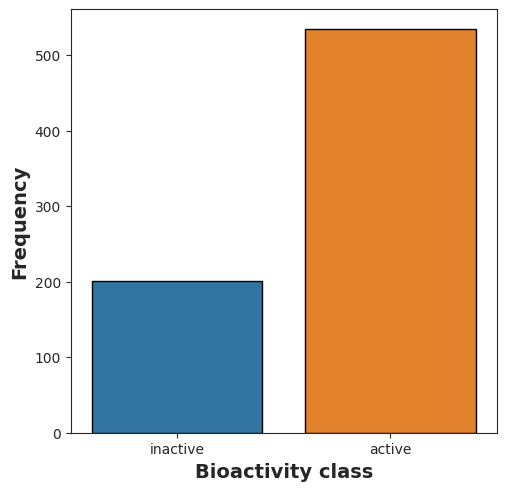

In [23]:
# This creates a new figure of size 5.5 inches by 5.5 inches
plt.figure(figsize=(5.5, 5.5))

# Using seaborn, we create a 'countplot' that will display the number of drugs that are either classified as inactive or active
sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black', hue = "bioactivity_class")

# We add x and y labels to the figure
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# We save the figure as a .pdf file and give it a name
plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot of MW versus LogP

We can visually show the relationship between molecular weight (MW) vs. octanol-water partition coefficient (LogP).

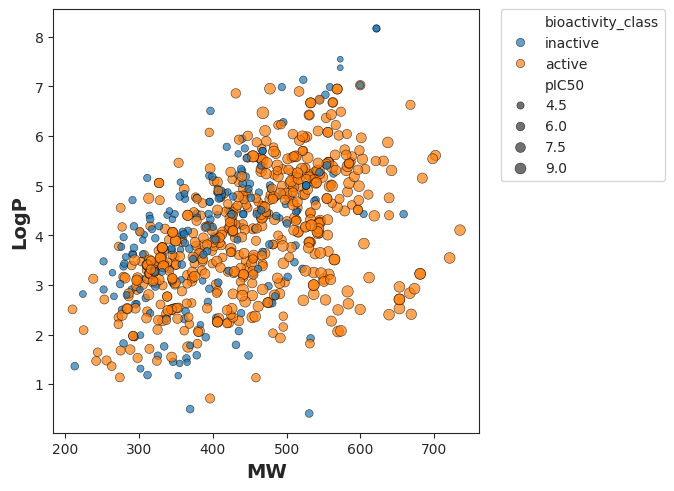

In [24]:
plt.figure(figsize=(5.5, 5.5))

# Using seaborn, we can create a scatterplot that will show the relationship between MW and LogP. We can specify the hue of the dots (representing drugs) to be coded based on which bioactivity class they belong to and the size of the dots to differ based on the pIC50 value.
sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

# Add x and y axis labels
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

# Add a legend to define the color and size codes
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Save the figure and name it
plt.savefig('plot_MW_vs_LogP.pdf')

### Box plots
With box plots we can see the distribution of data within each bioactivity class.

#### pIC50 Value

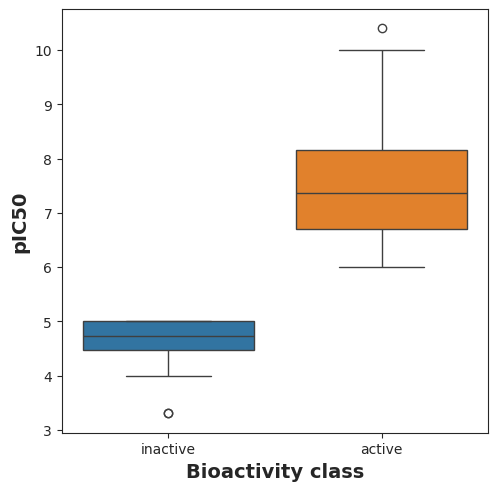

In [25]:
plt.figure(figsize=(5.5, 5.5))

# Using Seaborn you can create a boxplot with x-axis as the different bioactivity class and y-axis as the PIC50 values
sns.boxplot(x = 'bioactivity_class', y='pIC50', data=df_2class, hue='bioactivity_class')

# Add x- and y- axis labels
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')

# Save the figure
plt.savefig('plot_ic50.pdf')

#### Statistical analysis | Mann-Whitney U Test

This is a non-parametric statistical test that compares outcome between two independent groups and tests if these two groups are likely to derive from the same population. Non-parametric statistical tests state the null hypothesis as "The populations are equal" vs. two-sided research hypothesis as "The two populations are not equal".

**Here, we are going to ask if a Lipinski descriptor shows statistically significant difference between the bioactivity classes.**

In [26]:
# Here we pass the descriptor parameter with a Lipinski descriptor
def mannwhitney(descriptor, verbose=False):
    # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    from numpy.random import seed
    from  scipy.stats import mannwhitneyu

    seed(1)

    # Selection list stores the Lipinski descriptor and the string 'bioactivity_class'
    selection = [descriptor, 'bioactivity_class']
    # Define a new array as a df that only contains the Lipinksi descriptor and bioactivity class columns for each drug
    df = df_2class[selection]
    # Active is defined as the rows in df that have the 'active' descriptor in the bioactivity class column. Then save the Lipinski descriptor value that is associated with 'active' in the active array.
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]

    # Do the same for the inactive bioactivity class
    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]

    # Compare samples
    stat, p = mannwhitneyu(active, inactive)

    # Tnterpret the statistics
    # We set the alpha level to be 0.05
    alpha = 0.05
    # If the calculated p-value is larger than the alpha, this means that difference between the inactive and active classes is statistically significant or that we can't reject the H0
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    # Else the calculated p-value is smaller than the alpha, this means that the difference between the inactive and active classes is statistically unsignificant or that we can reject the H0
    else:
        interpretation = 'Different distribution (reject H0)'

    # Here we create a 1-row data frame to show the summary of the analysis: Lipinski descriptor used, Statistics calculated by the ann Whitney U Test, the p-value calculated, alpha level, and the interpretation of the p-value based on the alpha level.
    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index=[0])
    # Save the 1 row data frame in a .csv file
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    # Return the 1 row data frame
    return results

In [27]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,107334.0,2.713656e-97,0.05,Different distribution (reject H0)


We see that through the Mann Whitney U Test, there is a significant difference in pIC50 values between the 2 bioactivity classes (p < alpha). Thus, we reject the H0.

NOTE: this is expected because we used the pIC50 values to define the bioactivity characterization, where pIC50 > 6 = Active (IC50 < 1,000 nM) and pIC50 < 5 = Inactive (IC50 > 10,000 nM).

#### MW

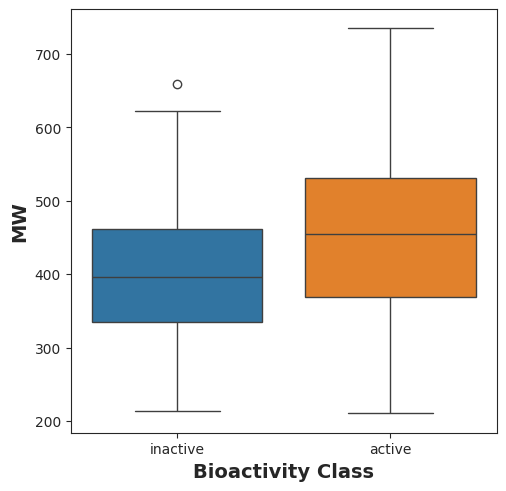

In [28]:
plt.figure(figsize=(5.5, 5.5))

# Using Seaborn we create a boxplot to visualize the distribution of data between the 2 bioactivity classes
sns.boxplot(x='bioactivity_class', y='MW', data=df_2class, hue='bioactivity_class')

# Add the x- and y-axis labels
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

# Save the figure
plt.savefig('plot_MW.pdf')

In [29]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,69053.0,2.016617e-09,0.05,Different distribution (reject H0)


We see that through the Mann Whitney U Test, there is a significant difference in molecular weight between the 2 bioactivity classes (p < alpha). Thus, we reject the H0.

#### LogP

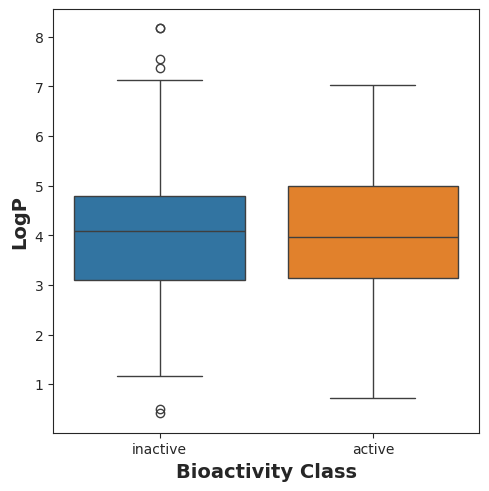

In [30]:
plt.figure(figsize=(5.5, 5.5))

# Use Seaborn to create a boxplot of the 2 different bioactivity classes
sns.boxplot(x='bioactivity_class', y='LogP', data=df_2class, hue='bioactivity_class')

# Add the x- and y-axis labels
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

# Save the figure
plt.savefig('plot_LogP.pdf')

In [31]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,54563.0,0.727075,0.05,Same distribution (fail to reject H0)


We see that through the Mann Whitney U Test, there is no significant difference in LogP values between the 2 bioactivity classes (p > alpha). Thus, we fail to reject the H0.

#### NumHDonors

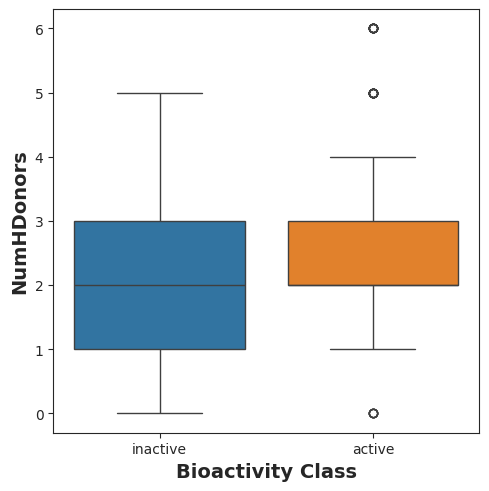

In [32]:
plt.figure(figsize=(5.5, 5.5))

# Use Seaborn to create a boxplot of NumHDonors for both bioactivity classes
sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_2class, hue='bioactivity_class')

# Add x- and y-axis labels
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

# Save the figure
plt.savefig('plot_NumHDonors.pdf')

In [33]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,65909.5,6.059907e-07,0.05,Different distribution (reject H0)


We see that through the Mann Whitney U Test, there is a significant difference in the number of hydrogen donors between the 2 bioactivity classes (p < alpha). Thus, we reject the H0.

#### NumHAcceptors

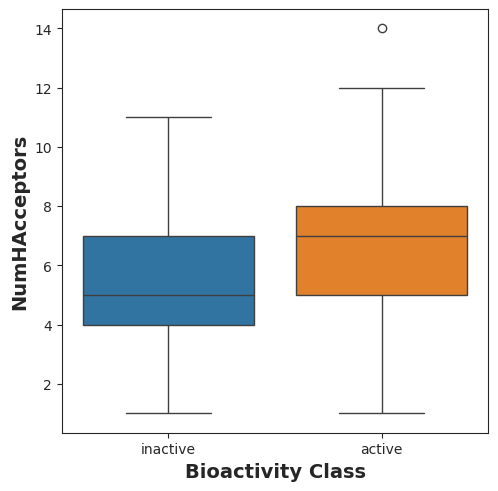

In [34]:
plt.figure(figsize=(5.5, 5.5))

# Use Seaborn to create a boxplot on the NumHAcceptors for both of the bioactivity classes
sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data=df_2class, hue='bioactivity_class')

# Add x- and y-axis labels
plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

# Save the figure
plt.savefig('plot_NumHAcceptors.pdf')

In [35]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,71314.5,3.560857e-12,0.05,Different distribution (reject H0)


We see that through the Mann Whitney U Test, there is a significant difference in the number of hydrogen acceptors between the 2 bioactivity classes (p < alpha). Thus, we reject the H0.

### Interpretation of Statistical Results

#### Lipinski's Descriptors
Of the 4 Lipinski's Descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP showed **no difference** between the **active** and **inactive** classes, while the other 3 descriptors showed **statistically significant difference** between the **active** and **inactive** classes.


## Zip files

In [36]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_MW_vs_LogP.pdf (deflated 5%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: plot_NumHDonors.pdf (deflated 37%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: RET_03_bioactivity_data_pIC50.csv (deflated 75%)
  adding: plot_NumHAcceptors.pdf (deflated 36%)
  adding: plot_ic50.pdf (deflated 36%)
  adding: RET_03_bioactivity_data_curated.csv (deflated 79%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_MW.pdf (deflated 38%)
